# 🏦 GESTÃO DE RISCO: MODELO DE SCORING BASILEIA (PD)
**Mesa de Operações:** Risco de Crédito Comercial
**Objetivo:** Calcular a Probabilidade de Default (PD) para o cálculo da Perda Esperada ($EL = PD \times LGD \times EAD$).

## 1. Setup e Governança de Infraestrutura
Este bloco inicializa o radar de navegação e a blindagem do código.
* **Hot Reload (`%autoreload`):** Mitiga o Risco Operacional de memória em cache. Permite que o Jupyter leia atualizações na biblioteca central (`src/`) em tempo real, sem necessidade de reiniciar o servidor (Zero Downtime).
* **Isolamento de Domínio (`src/`):** A matemática pesada e as regras de negócio foram encapsuladas fora do Notebook para garantir rastreabilidade e evitar execução de células fora de ordem.

In [1]:
# ===================================================================
# CÉLULA 1: INICIALIZAÇÃO, INGESTÃO E HIGIENE COMPLETA (V2)
# ===================================================================
%load_ext autoreload
%autoreload 2

import sys, pandas as pd, numpy as np
from pathlib import Path

pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

raiz = Path.cwd() if Path.cwd().joinpath('src').exists() else Path.cwd().parent
sys.path.append(str(raiz))

from src.data_ingestion import carregar_base_basileia
from src.feature_engineering import (
    definir_variavel_alvo, 
    remover_colunas_toxicas, 
    imputar_dados_nulos, 
    categorizar_renda_dti, 
    dividir_treino_teste,
    padronizar_tempo_emprego,    
    calcular_historico_credito,
    padronizar_home_ownership
)

# Gaveta da Matemática
from src.woe_iv import calcular_woe_iv, injetar_woe_na_base
from src.plots_woe import auditar_tendencia_woe, auditar_curva_roc

#  Gaveta de Escalonamento
from src.scorecard_scaler import calcular_score_final, aplicar_politica_decisao_original, aplicar_politica_decisao_quartis 

print("STATUS: Iniciando Ingestão de Dados e Protocolo de Trauma...")

loan_data = carregar_base_basileia()
loan_data = definir_variavel_alvo(loan_data)
loan_data = padronizar_home_ownership(loan_data)

# TRATAMENTO DE CHOQUE (Limpeza)
loan_data = remover_colunas_toxicas(loan_data, limite_toxicidade=0.50)
loan_data = imputar_dados_nulos(loan_data)

# ENGENHARIA DE FEATURES (Resgatando as Variáveis Fantasmas)
# 1. Aplicando a inteligência temporal que estava esquecida
loan_data['emp_length_num'] = padronizar_tempo_emprego(loan_data)
loan_data['meses_historico_credito'] = calcular_historico_credito(loan_data, 'issue_d')

# 2. Aplicando a inteligência FGV e Filtro de 18k
loan_data = categorizar_renda_dti(loan_data)

print(f"STATUS: Cockpit do V2 alinhado. Total de CPFs: {len(loan_data)}")

STATUS: Iniciando Ingestão de Dados e Protocolo de Trauma...
STATUS: Rota confirmada. Iniciando leitura de loan_data_2007_2014.csv...
SUCESSO: 466285 linhas extraídas para a RAM.
STATUS: Cockpit do V2 alinhado. Total de CPFs: 461781


## 3. Auditoria de Dívida Técnica (Missing Data)
Antes da injeção na Regressão Logística, a matriz $(X^T X)^{-1}$ não pode conter valores nulos (`NaN`), sob pena de matriz singular e colapso do motor.

**Protocolo de Imputação vs. Drop:**
* Este radar varre a base em busca de furos na fuselagem.
* Variáveis com nulos marginais (< 5%) serão tratadas no nosso "Hospital de Dados" (`src/`) usando Proxies Financeiras ou preenchimento conservador (ex: assumir zero para valores em cobrança não reportados), preservando a integridade do Capital do banco.

In [2]:
# ===================================================================
# CÉLULA 2: AUDITORIA DE DÍVIDA TÉCNICA (NULOS)
# ===================================================================

print("STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...")

# 1. A Matemática do Rombo
total_linhas = len(loan_data)
nulos_abs = loan_data.isnull().sum()
nulos_perc = (nulos_abs / total_linhas) * 100

# 2. A Construção do Balanço Patrimonial (DataFrame limpo)
relatorio_nulos = pd.DataFrame({
    'Total_Vazios': nulos_abs,
    'Percentual (%)': nulos_perc
})

# 3. O Filtro de Toxicidade: Queremos ver apenas quem tem rombo, do pior (maior %) para o melhor
relatorio_nulos = relatorio_nulos[relatorio_nulos['Total_Vazios'] > 0].sort_values(by='Percentual (%)', ascending=False)

print(f"ALERTA: O radar detectou {len(relatorio_nulos)} variáveis com dados faltantes na fuselagem.\n")
display(relatorio_nulos.head(15)) # Imprime as 15 variáveis mais tóxicas

STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...
ALERTA: O radar detectou 18 variáveis com dados faltantes na fuselagem.



,Total_Vazios,Percentual (%)
next_pymnt_d,224834,48.6884
tot_cur_bal,68901,14.9207
tot_coll_amt,68901,14.9207
emp_title,25803,5.5877
emp_length,19324,4.1847
emp_length_num,19324,4.1847
last_pymnt_d,361,0.0782
revol_util,315,0.0682
collections_12_mths_ex_med,119,0.0258
last_credit_pull_d,42,0.0091


In [3]:
# ===================================================================
# CÉLULA 2.5: AUDITORIA DE HIGIENE (RENDA ANUAL)
# ===================================================================
print("STATUS: Auditando a sanidade da Renda após o filtro de Sobrevivência...\n")

# O Diretor quer ver se realmente cortamos a base da pirâmide extrema
resumo_renda = loan_data['annual_inc'].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
display(resumo_renda.to_frame().T)

print("\nLAUDO DO AUDITOR: Se o valor 'min' for >= 18356, a base está blindada contra lixo operacional.")

STATUS: Auditando a sanidade da Renda após o filtro de Sobrevivência...



,count,mean,std,min,5%,25%,50%,75%,95%,max
annual_inc,461781.0000,73848.4810,54923.2007,18360.0000,30000.0000,45000.0000,63000.0000,89000.0000,150000.0000,7500000.0000



LAUDO DO AUDITOR: Se o valor 'min' for >= 18356, a base está blindada contra lixo operacional.


In [4]:
# ===================================================================
# CÉLULA 3: FATIAMENTO V2 E PREPARAÇÃO PARA O MOTOR
# ===================================================================
print("STATUS: Fatiando a Base V2 (Treino e Teste)...")

coluna_alvo = 'good_bad_loan' 

if coluna_alvo in loan_data.columns:
    X_train, X_test, y_train, y_test = dividir_treino_teste(loan_data, target_col=coluna_alvo)
    df_treino_woe = pd.concat([X_train, y_train], axis=1)
    print(f"STATUS: Fatiamento concluído com sucesso.")
    print(f"Volume de Treino: {X_train.shape[0]} Clientes | Volume de Teste: {X_test.shape[0]} Clientes")
else:
    print(f"ERRO CRÍTICO: A coluna '{coluna_alvo}' sumiu da base. Abortar operação.")

STATUS: Fatiando a Base V2 (Treino e Teste)...
STATUS: Fatiamento concluído com sucesso.
Volume de Treino: 369424 Clientes | Volume de Teste: 92357 Clientes


STATUS: Iniciando o Scanner de Risco nas variáveis da esteira...


 STATUS: Gerando Laudo de Risco >>> GRADE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


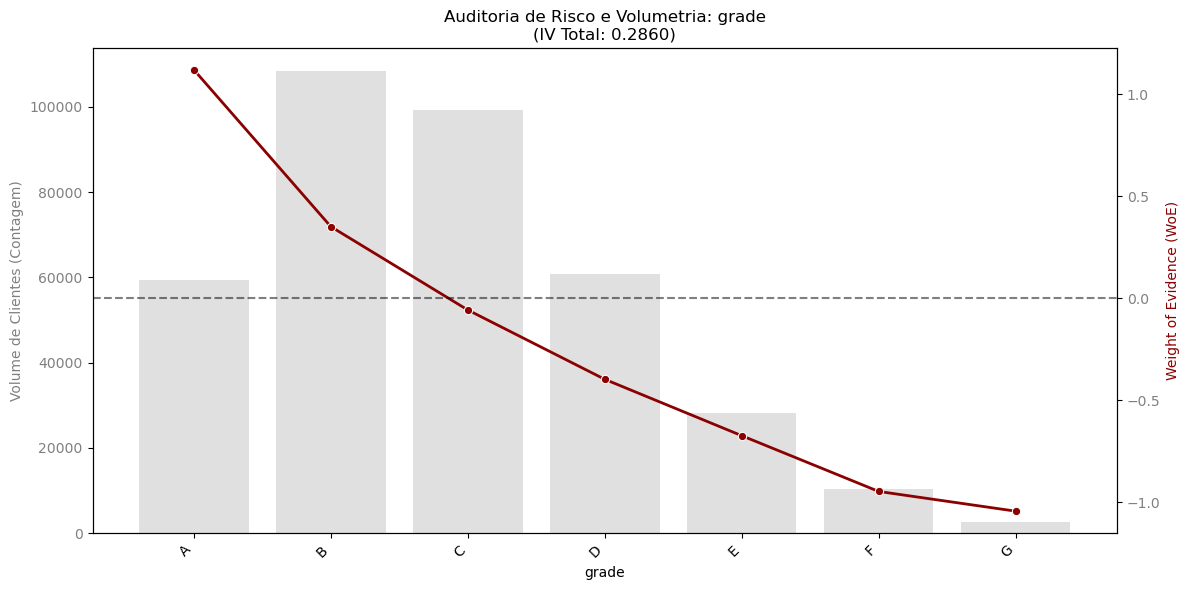


 STATUS: Gerando Laudo de Risco >>> HOME_OWNERSHIP <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


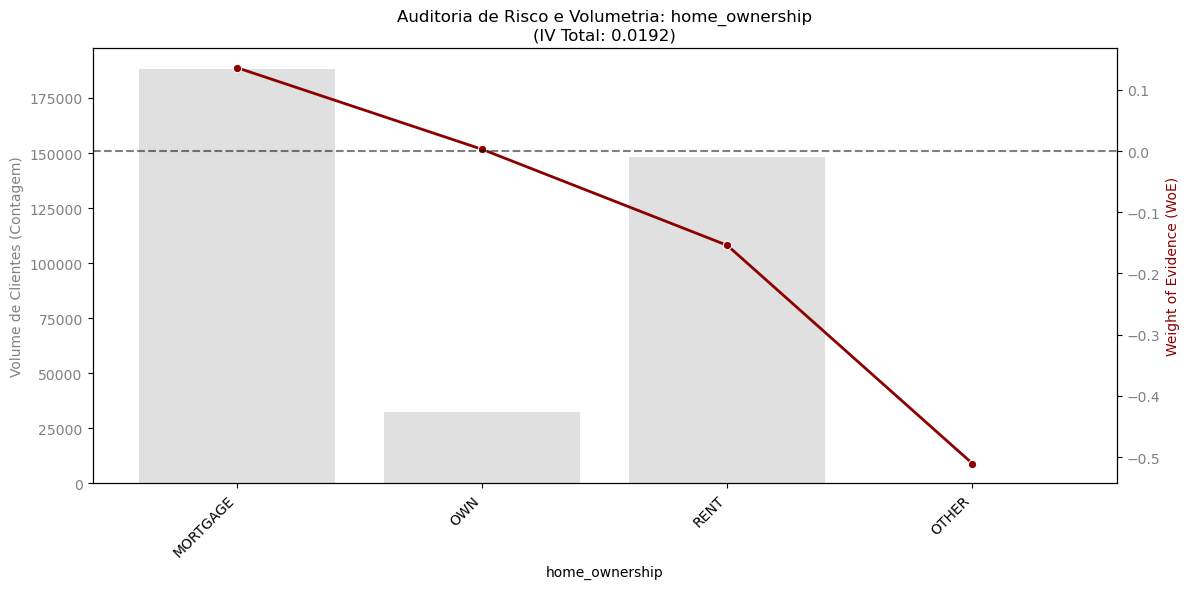


 STATUS: Gerando Laudo de Risco >>> PURPOSE <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


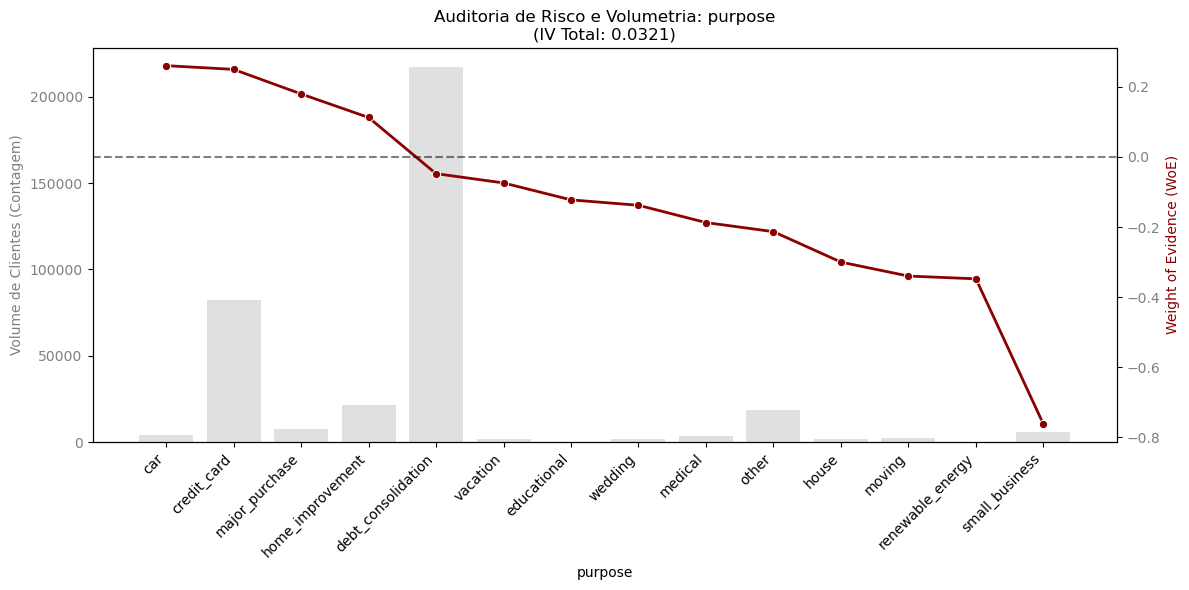


 STATUS: Gerando Laudo de Risco >>> VERIFICATION_STATUS <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


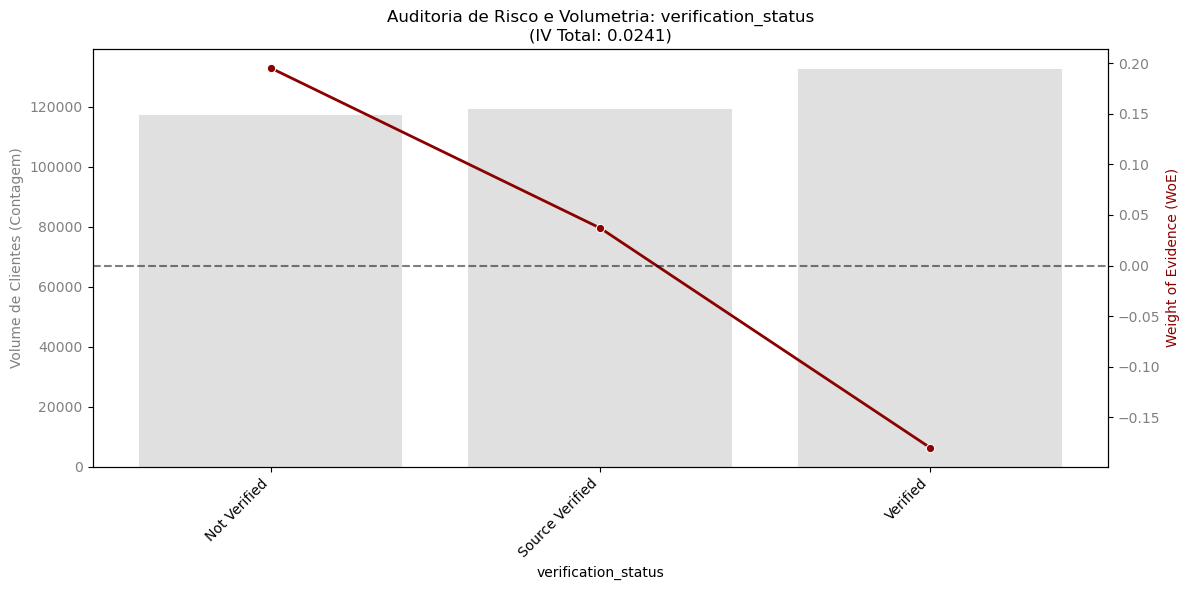


 STATUS: Gerando Laudo de Risco >>> FAIXA_RENDA <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


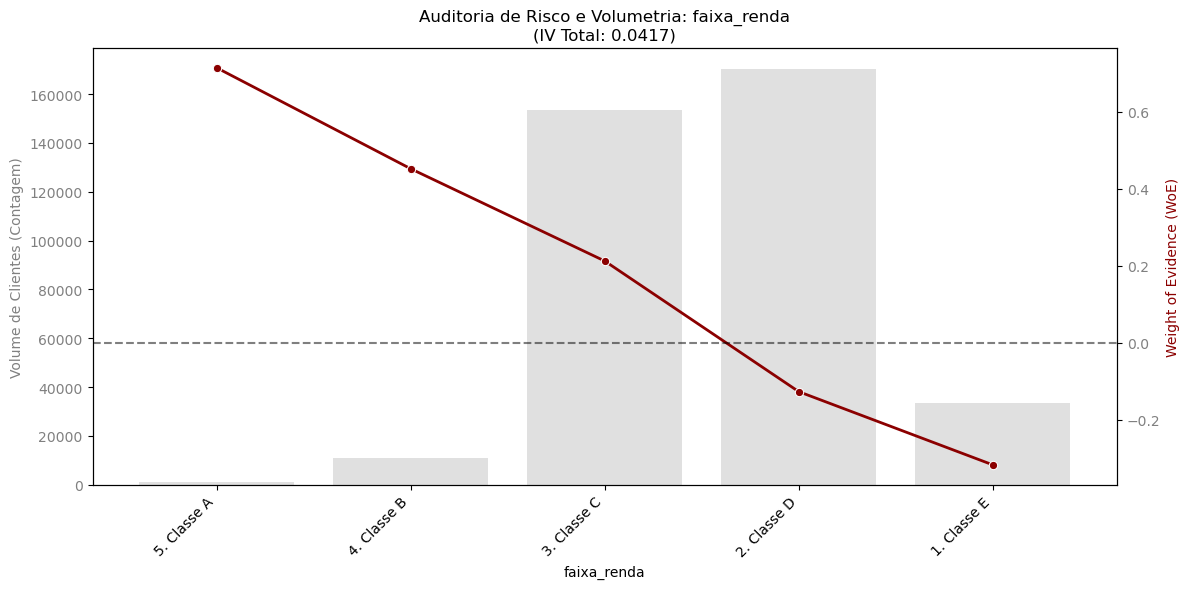


 STATUS: Gerando Laudo de Risco >>> FAIXA_DTI <<<


C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling\src\plots_woe.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')


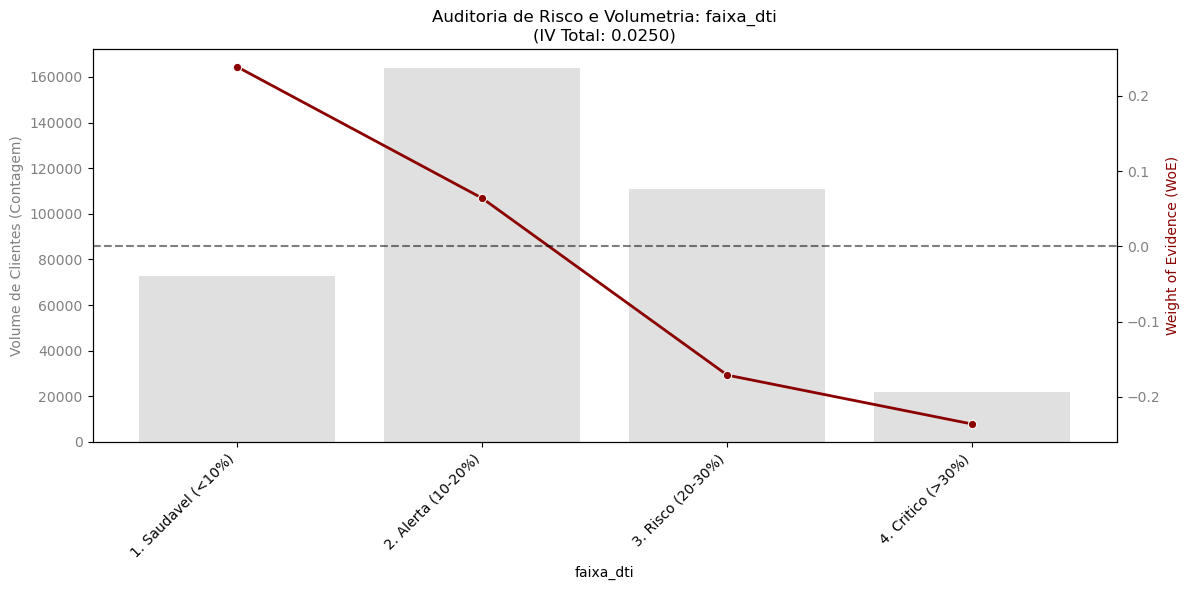

In [5]:
# ===================================================================
# CÉLULA 4: MOTOR DE AUDITORIA V2 (SCANNER VISUAL DE RISCO)
# ===================================================================
colunas_para_testar = [
    'grade', 
    'home_ownership', 
    'purpose', 
    'verification_status',
    'faixa_renda',  # A Inteligência da FGV Social
    'faixa_dti'     # O Risco de Alavancagem
]

print("STATUS: Iniciando o Scanner de Risco nas variáveis da esteira...\n")

for coluna in colunas_para_testar:
    if coluna in df_treino_woe.columns:
        print(f"\n{'='*70}")
        print(f" STATUS: Gerando Laudo de Risco >>> {coluna.upper()} <<<")
        print(f"{'='*70}")
        
        df_tabela_woe = calcular_woe_iv(df_treino_woe, coluna, 'good_bad_loan')
        auditar_tendencia_woe(df_tabela_woe, coluna)
    else:
        print(f"ALERTA: A variável '{coluna}' não foi encontrada.")

In [6]:
# ===================================================================
# CÉLULA 5: INJEÇÃO DE PESOS DE RISCO TURBINADA (WoE)
# ===================================================================
print("STATUS: Iniciando injeção de pesos matemáticos (WoE) no Chassi V2...")

for col in colunas_para_testar:
    df_ref_woe = calcular_woe_iv(df_treino_woe, col, 'good_bad_loan')
    X_train = injetar_woe_na_base(X_train, df_ref_woe, col)
    X_test = injetar_woe_na_base(X_test, df_ref_woe, col)

print("STATUS: Sucesso. Base V2 transformada em puro risco matemático.")
display(X_train[[f"{c}_woe" for c in colunas_para_testar]].head())

STATUS: Iniciando injeção de pesos matemáticos (WoE) no Chassi V2...
STATUS: Sucesso. Base V2 transformada em puro risco matemático.


,grade_woe,home_ownership_woe,purpose_woe,verification_status_woe,faixa_renda_woe,faixa_dti_woe
131178,0.3522,0.1360,0.2498,-0.1798,-0.3171,-0.1713
375467,-0.3963,0.1360,-0.1871,-0.1798,-0.1271,0.0639
418791,1.1208,0.0027,-0.0476,0.1952,-0.1271,-0.1713
350881,0.3522,0.1360,-0.0476,-0.1798,-0.1271,0.2387
276823,1.1208,-0.1541,-0.0476,0.0370,0.2120,0.2387


In [7]:
# ===================================================================
# CÉLULA 6: O CÉREBRO DO SCORECARD V2 (REGRESSÃO LOGÍSTICA)
# ===================================================================
from sklearn.linear_model import LogisticRegression

colunas_woe_v2 = [f"{c}_woe" for c in colunas_para_testar]

print("STATUS: Iniciando treinamento do Modelo Campeão (V2)...")

modelo_v2 = LogisticRegression(max_iter=1000, random_state=42)
modelo_v2.fit(X_train[colunas_woe_v2], y_train)

print("STATUS: Sucesso. O motor V2 foi calibrado com Renda (FGV) e DTI.")

# Auditoria de Pesos
pesos_v2 = pd.DataFrame({
    'Variável_Sensor': colunas_woe_v2, 
    'Peso_Matemático': modelo_v2.coef_[0]
}).sort_values(by='Peso_Matemático', ascending=False)

print("\n--- RANKING DE IMPORTÂNCIA DO MODELO V2 ---")
display(pesos_v2)

STATUS: Iniciando treinamento do Modelo Campeão (V2)...
STATUS: Sucesso. O motor V2 foi calibrado com Renda (FGV) e DTI.

--- RANKING DE IMPORTÂNCIA DO MODELO V2 ---


,Variável_Sensor,Peso_Matemático
0,grade_woe,0.9071
4,faixa_renda_woe,0.8296
3,verification_status_woe,0.5176
1,home_ownership_woe,0.5127
2,purpose_woe,0.5105
5,faixa_dti_woe,0.4096


In [8]:
# ===================================================================
# CÉLULA 7: AUDITORIA PREDITIVA (GINI DO V2)
# ===================================================================
from sklearn.metrics import roc_auc_score

print("STATUS: Extraindo probabilidades e auditando o poder preditivo...")

# O robô prevê o calote na base cega
probabilidades_calote = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 1]

# Calculamos as métricas de mercado
auc = roc_auc_score(y_test, probabilidades_calote)
gini = (auc * 2) - 1

print(f"{'='*50}")
print(f" STATUS: Auditoria Preditiva Concluída.")
print(f" Métrica AUC:  {auc:.4f}")
print(f" Métrica GINI: {gini:.4f} ({gini*100:.2f}%)")
print(f"{'='*50}")

# Gerando os Scores para a próxima etapa
X_test['Score_Final'] = calcular_score_final(probabilidades_calote)

STATUS: Extraindo probabilidades e auditando o poder preditivo...
 STATUS: Auditoria Preditiva Concluída.
 Métrica AUC:  0.6641
 Métrica GINI: 0.3282 (32.82%)


In [9]:
# ===================================================================
# AUDITORIA ESTATÍSTICA: A PROVA REAL DA MATEMÁTICA (BLINDADA)
# ===================================================================
from sklearn.metrics import roc_auc_score
import numpy as np

print("STATUS: Iniciando Teste de Estresse Matemático...\n")

# 1. Geração Independente de Probabilidades (Evita NameError e Vazamento)
# Recalculamos as probabilidades aqui para garantir isolamento da auditoria
prob_treino_lucro = modelo_v2.predict_proba(X_train[colunas_woe_v2])[:, 1]
prob_teste_lucro = modelo_v2.predict_proba(X_test[colunas_woe_v2])[:, 1] # <-- A vacina contra o erro

# 2. Cálculo das Métricas de Separação
gini_treino = (roc_auc_score(y_train, prob_treino_lucro) * 2) - 1
gini_teste = (roc_auc_score(y_test, prob_teste_lucro) * 2) - 1

# --- TESTE 1: AUDITORIA DE OVERFITTING ---
print(f"1. LAUDO DE OVERFITTING:")
print(f"   GINI no Treino (O que ele viu): {gini_treino*100:.2f}%")
print(f"   GINI no Teste (O que ele não viu): {gini_teste*100:.2f}%")
if abs(gini_treino - gini_teste) > 0.05:
    print("   -> ALERTA VERMELHO: O modelo está decorando dados (Overfitting)!\n")
else:
    print("   -> SINAL VERDE: A matemática está estável entre as bases.\n")

# --- TESTE 2: AUDITORIA DE SINAIS DOS COEFICIENTES ---
print(f"2. LAUDO DE DIREÇÃO MATEMÁTICA (COEFICIENTES):")
pesos_negativos = pesos_v2[pesos_v2['Peso_Matemático'] < 0]
if len(pesos_negativos) > 0:
    print(f"   -> ALERTA VERMELHO: O robô inverteu a lógica de risco destas variáveis:")
    display(pesos_negativos)
else:
    print("   -> SINAL VERDE: Todos os pesos seguem a mesma direção do WoE. A lógica está intacta.\n")

# --- TESTE 3: AUDITORIA DA DISTRIBUIÇÃO DA BASE ---
taxa_calote_real = 1 - y_train.mean()
print(f"3. LAUDO DE DISTRIBUIÇÃO DA CARTEIRA:")
print(f"   Taxa de Calote Real na Base de Treino: {taxa_calote_real*100:.2f}%")
if taxa_calote_real < 0.05 or taxa_calote_real > 0.50:
    print("   -> ALERTA: Base fortemente desbalanceada. O GINI pode estar distorcido.\n")
else:
    print("   -> SINAL VERDE: Distribuição de risco aceitável para o algoritmo.\n")

STATUS: Iniciando Teste de Estresse Matemático...

1. LAUDO DE OVERFITTING:
   GINI no Treino (O que ele viu): 32.15%
   GINI no Teste (O que ele não viu): 32.82%
   -> SINAL VERDE: A matemática está estável entre as bases.

2. LAUDO DE DIREÇÃO MATEMÁTICA (COEFICIENTES):
   -> SINAL VERDE: Todos os pesos seguem a mesma direção do WoE. A lógica está intacta.

3. LAUDO DE DISTRIBUIÇÃO DA CARTEIRA:
   Taxa de Calote Real na Base de Treino: 10.72%
   -> SINAL VERDE: Distribuição de risco aceitável para o algoritmo.



STATUS: Gerando o Laudo Visual de Separação de Risco...



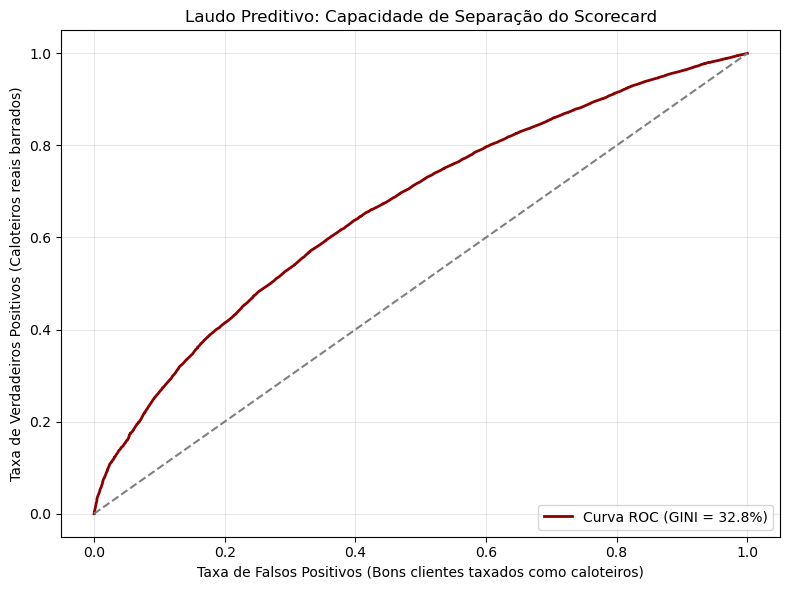

In [10]:
# ===================================================================
# CÉLULA 7.5: O LAUDO VISUAL DO COMITÊ (CURVA ROC)
# ===================================================================
print("STATUS: Gerando o Laudo Visual de Separação de Risco...\n")

# Chamamos a função limpa que você tem no src/plots_woe.py
auditar_curva_roc(y_test, probabilidades_calote, gini)

In [11]:
# ===================================================================
# CÉLULA 8: O LAUDO FINAL DO DIRETOR (LOSS EVITADO)
# ===================================================================
print("STATUS: Aplicando Política de Crédito e calculando Lucro...")

# 1. A Bifurcação (O Clone do Auditor)
df_comite_risco = X_test[['grade_woe', 'home_ownership_woe', 'Score_Final']].copy()
df_comite_risco['Calote_Real'] = y_test

# 2. Aplicamos o motor calibrado
df_comite_risco = aplicar_politica_decisao_quartis(df_comite_risco)

# 3. Cálculo do Loss Evitado (10k por calote barrado)
filtro_loss = (df_comite_risco['Decisao'] == 'REPROVADO') & (df_comite_risco['Calote_Real'] == 1)
clientes_barrados = df_comite_risco[filtro_loss].shape[0]
loss_evitado = clientes_barrados * 10000 

print(f"\n{'='*65}")
print(f" AUDITORIA FINAL DO V2: O modelo barrou {clientes_barrados} caloteiros reais.")
print(f" ESTIMATIVA DE LUCRO V2: R$ {loss_evitado:,.2f} em 'Loss' evitado.")
print(f"{'='*65}")

STATUS: Aplicando Política de Crédito e calculando Lucro...

 AUDITORIA FINAL DO V2: O modelo barrou 25136 caloteiros reais.
 ESTIMATIVA DE LUCRO V2: R$ 251,360,000.00 em 'Loss' evitado.
